In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os

2023-05-25 13:27:15.199385: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Dataset preparation

### Set parameters

In [2]:
batch_size = 8
img_height = 184
img_width = 216
img_size = (img_height, img_width)
img_shape = img_size + (3,)
ds_path = "/drive0-storage/Gracia/dataset"

### Load dataset

In [3]:
from tensorflow.keras.utils import image_dataset_from_directory

train_ds = image_dataset_from_directory(ds_path,
                                        validation_split = 0.2,
                                        subset = "training",
                                        seed = 123,
                                        image_size = img_size,
                                        batch_size = batch_size)

val_ds = image_dataset_from_directory(ds_path,
                                      validation_split = 0.2,
                                      subset = "validation",
                                      seed = 123,
                                      image_size = img_size,
                                      batch_size = batch_size)

Found 21408 files belonging to 3 classes.
Using 17127 files for training.


2023-05-25 13:27:17.912172: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-25 13:27:18.322156: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1637] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7910 MB memory:  -> device: 0, name: A100-SXM4-40GB MIG 2g.10gb, pci bus id: 0000:90:00.0, compute capability: 8.0


Found 21408 files belonging to 3 classes.
Using 4281 files for validation.


In [4]:
class_names = train_ds.class_names
num_classes = len(class_names)

print(class_names)

['bd', 'hc', 'sz']


### Test set

In [5]:
val_batches = tf.data.experimental.cardinality(val_ds)
test_dataset = val_ds.take(val_batches // 2)
validation_dataset = val_ds.skip(val_batches // 2)

In [6]:
# Buffered prefetching
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_ds.prefetch(buffer_size = AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size = AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size = AUTOTUNE)

In [7]:
print(f"train batches: {len(train_dataset)}")
print(f"validation batches: {len(validation_dataset)}")
print(f"test batches: {len(test_dataset)}")

train batches: 2141
validation batches: 268
test batches: 268


## Model building

### Transfer learning
Run one of the the following to load pretrained model

- ResNet50

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
pre_trained_model = ResNet50(input_shape = img_shape,
                        include_top = False,
                        weights = 'imagenet')

# pre_trained_model.trainable = False

- MobileNetV2

In [32]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input

pre_trained_model = MobileNetV2(input_shape = img_shape,
                        include_top = False,
                        weights = 'imagenet')

# pre_trained_model.trainable = False

- VGG16

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input

pre_trained_model = VGG16(input_shape = img_shape,
                        include_top = False,
                        weights = 'imagenet')

# pre_trained_model.trainable = False

- InceptionV3

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input

pre_trained_model = InceptionV3(input_shape = img_shape,
                        include_top = False,
                        weights = 'imagenet')

# pre_trained_model.trainable = False

In [ ]:
pre_trained_model.summary()

### Fine tuning layers

In [33]:
print("Number of layers: ", len(pre_trained_model.layers))

Number of layers:  154


In [34]:
pre_trained_model.trainable = True

# Fine-tune from this layer onwards
START_TRAIN = 144

# Freeze all the layers before 
for layer in pre_trained_model.layers[:START_TRAIN]:
    layer.trainable = False

### Preprocess input and add classification layer

In [35]:
global_average = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(num_classes, activation='softmax')

inputs = tf.keras.Input(shape = img_shape)
x = preprocess_input(inputs)
x = pre_trained_model(x, training=False)
x = global_average(x)
x = tf.keras.layers.Dropout(0.3)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs,outputs)

### Compile model

In [ ]:
# Compile model
LR = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = LR),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
              metrics=['accuracy'])

# Display model architecture
model.summary()

### Model from scratch

In [44]:
rescale = tf.keras.layers.Rescaling(1./255) 

en_cnn = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(128, (3,3), activation='relu', input_shape=img_shape),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.Conv2D(16, (3,3), activation='relu'),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Conv2D(16, (3,3), activation='relu'),
    tf.keras.layers.Conv2D(16, (3,3), activation='relu'),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

# Chain model
inputs = tf.keras.Input(shape = img_shape)
x = rescale(inputs)
outputs = en_cnn(x)
model = tf.keras.Model(inputs,outputs)

# Compile model
lr = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = lr),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
              metrics=['accuracy'])

# Display model architecture
en_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_101 (Conv2D)         (None, 182, 214, 128)     3584      
                                                                 
 re_lu_4 (ReLU)              (None, 182, 214, 128)     0         
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 91, 107, 128)     0         
 2D)                                                             
                                                                 
 conv2d_102 (Conv2D)         (None, 89, 105, 64)       73792     
                                                                 
 conv2d_103 (Conv2D)         (None, 87, 103, 32)       18464     
                                                                 
 re_lu_5 (ReLU)              (None, 87, 103, 32)       0         
                                                      

## Model training

In [14]:
# Callback function
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy')>0.90):
            print("\nReached 90% accuracy so cancelling training!")
            self.model.stop_training = True
            
callbacks = myCallback()

- ResNet50

In [30]:
EPOCH = 15
#trained from layer 166
history_resnet = model.fit(
            train_dataset,
            validation_data = validation_dataset,
            epochs = EPOCH)
#             callbacks=[callbacks])

Epoch 1/15
2141/2141 [==============================] - 47s 21ms/step - loss: 0.9542 - accuracy: 0.5711 - val_loss: 0.8881 - val_accuracy: 0.5849
Epoch 2/15
2141/2141 [==============================] - 43s 20ms/step - loss: 0.8237 - accuracy: 0.6326 - val_loss: 0.7704 - val_accuracy: 0.6401
Epoch 3/15
2141/2141 [==============================] - 42s 20ms/step - loss: 0.6478 - accuracy: 0.7185 - val_loss: 0.6943 - val_accuracy: 0.6898
Epoch 4/15
2141/2141 [==============================] - 43s 20ms/step - loss: 0.4579 - accuracy: 0.8126 - val_loss: 0.5511 - val_accuracy: 0.7749
Epoch 5/15
2141/2141 [==============================] - 42s 20ms/step - loss: 0.2869 - accuracy: 0.8863 - val_loss: 0.4248 - val_accuracy: 0.8315
Epoch 6/15
2141/2141 [==============================] - 42s 20ms/step - loss: 0.1774 - accuracy: 0.9333 - val_loss: 0.5477 - val_accuracy: 0.8226
Epoch 7/15
2141/2141 [==============================] - 42s 20ms/step - loss: 0.1338 - accuracy: 0.9514 - val_loss: 0.4613 -

- MobileNetV2

In [38]:
EPOCH = 15
#train from layer 144
history_mobilenet = model.fit(
            train_dataset,
            validation_data = validation_dataset,
            epochs = EPOCH)
#             callbacks=[callbacks])

Epoch 1/15
2141/2141 [==============================] - 25s 11ms/step - loss: 0.9792 - accuracy: 0.5558 - val_loss: 0.9391 - val_accuracy: 0.5531
Epoch 2/15
2141/2141 [==============================] - 22s 10ms/step - loss: 0.9423 - accuracy: 0.5692 - val_loss: 0.8993 - val_accuracy: 0.5849
Epoch 3/15
2141/2141 [==============================] - 22s 10ms/step - loss: 0.8939 - accuracy: 0.5977 - val_loss: 0.8760 - val_accuracy: 0.5920
Epoch 4/15
2141/2141 [==============================] - 21s 10ms/step - loss: 0.8476 - accuracy: 0.6181 - val_loss: 0.8542 - val_accuracy: 0.6107
Epoch 5/15
2141/2141 [==============================] - 22s 10ms/step - loss: 0.7941 - accuracy: 0.6494 - val_loss: 0.8023 - val_accuracy: 0.6341
Epoch 6/15
2141/2141 [==============================] - 21s 10ms/step - loss: 0.7355 - accuracy: 0.6812 - val_loss: 0.8178 - val_accuracy: 0.6313
Epoch 7/15
2141/2141 [==============================] - 21s 10ms/step - loss: 0.6793 - accuracy: 0.7122 - val_loss: 0.7505 -

- VGG16

In [13]:
EPOCH = 15
#train from layer 10
history_vgg = model.fit(
            train_dataset,
            validation_data = validation_dataset,
            epochs = EPOCH)
#             callbacks=[callbacks])

Epoch 1/15


2023-05-25 13:27:35.162150: I tensorflow/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-05-25 13:27:35.882180: I tensorflow/stream_executor/cuda/cuda_blas.cc:1633] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


2141/2141 [==============================] - 62s 28ms/step - loss: 1.0252 - accuracy: 0.5487 - val_loss: 1.0103 - val_accuracy: 0.5391
Epoch 2/15
2141/2141 [==============================] - 58s 27ms/step - loss: 1.0024 - accuracy: 0.5576 - val_loss: 1.0055 - val_accuracy: 0.5433
Epoch 3/15
2141/2141 [==============================] - 58s 27ms/step - loss: 0.9861 - accuracy: 0.5577 - val_loss: 0.9595 - val_accuracy: 0.5414
Epoch 4/15
2141/2141 [==============================] - 58s 27ms/step - loss: 0.9251 - accuracy: 0.5762 - val_loss: 0.8605 - val_accuracy: 0.6027
Epoch 5/15
2141/2141 [==============================] - 58s 27ms/step - loss: 0.7719 - accuracy: 0.6537 - val_loss: 0.6936 - val_accuracy: 0.6958
Epoch 6/15
2141/2141 [==============================] - 57s 27ms/step - loss: 0.4745 - accuracy: 0.8011 - val_loss: 0.5102 - val_accuracy: 0.8039
Epoch 7/15
2141/2141 [==============================] - 58s 27ms/step - loss: 0.2115 - accuracy: 0.9207 - val_loss: 0.4207 - val_accura

- InceptionV3

In [23]:
EPOCH = 15
#trained from layer 301
history_inception = model.fit(
            train_dataset,
            validation_data = validation_dataset,
            epochs = EPOCH)
#             callbacks=[callbacks])

Epoch 1/15
2141/2141 [==============================] - 35s 15ms/step - loss: 1.1855 - accuracy: 0.4750 - val_loss: 0.9977 - val_accuracy: 0.5419
Epoch 2/15
2141/2141 [==============================] - 30s 14ms/step - loss: 1.0987 - accuracy: 0.5032 - val_loss: 0.9855 - val_accuracy: 0.5489
Epoch 3/15
2141/2141 [==============================] - 30s 14ms/step - loss: 1.0455 - accuracy: 0.5205 - val_loss: 0.9579 - val_accuracy: 0.5550
Epoch 4/15
2141/2141 [==============================] - 29s 14ms/step - loss: 1.0127 - accuracy: 0.5362 - val_loss: 0.9469 - val_accuracy: 0.5629
Epoch 5/15
2141/2141 [==============================] - 30s 14ms/step - loss: 0.9948 - accuracy: 0.5372 - val_loss: 0.9397 - val_accuracy: 0.5601
Epoch 6/15
2141/2141 [==============================] - 29s 14ms/step - loss: 0.9793 - accuracy: 0.5491 - val_loss: 0.9354 - val_accuracy: 0.5639
Epoch 7/15
2141/2141 [==============================] - 29s 14ms/step - loss: 0.9647 - accuracy: 0.5549 - val_loss: 0.9415 -

- From scratch

In [45]:
EPOCH = 15

history_cnn = model.fit(
            train_dataset,
            validation_data = validation_dataset,
            epochs = EPOCH)
#             callbacks=[callbacks])

Epoch 1/15
2141/2141 [==============================] - 39s 18ms/step - loss: 0.9989 - accuracy: 0.5575 - val_loss: 1.0196 - val_accuracy: 0.5381
Epoch 2/15
2141/2141 [==============================] - 38s 18ms/step - loss: 0.9949 - accuracy: 0.5578 - val_loss: 1.0134 - val_accuracy: 0.5405
Epoch 3/15
2141/2141 [==============================] - 38s 18ms/step - loss: 0.9930 - accuracy: 0.5578 - val_loss: 1.0076 - val_accuracy: 0.5419
Epoch 4/15
2141/2141 [==============================] - 38s 18ms/step - loss: 0.9878 - accuracy: 0.5578 - val_loss: 0.9927 - val_accuracy: 0.5395
Epoch 5/15
2141/2141 [==============================] - 38s 18ms/step - loss: 0.9629 - accuracy: 0.5617 - val_loss: 0.9598 - val_accuracy: 0.5545
Epoch 6/15
2141/2141 [==============================] - 38s 18ms/step - loss: 0.9379 - accuracy: 0.5772 - val_loss: 0.9365 - val_accuracy: 0.5686
Epoch 7/15
2141/2141 [==============================] - 38s 18ms/step - loss: 0.9141 - accuracy: 0.5869 - val_loss: 0.9146 -

### Training evaluation

- ResNet50

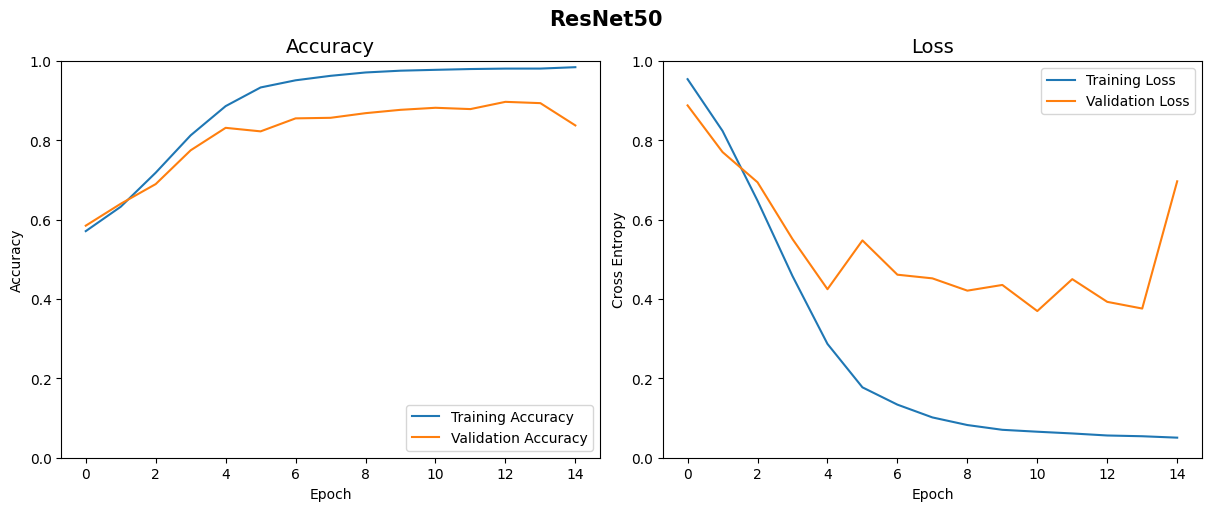

In [31]:
# training and validation accuracy
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5), constrained_layout=True)

acc = history_resnet.history['accuracy']
val_acc = history_resnet.history['val_accuracy']

ax[0].plot(acc, label='Training Accuracy')
ax[0].plot(val_acc, label='Validation Accuracy')
ax[0].legend(loc='lower right')
ax[0].set(xlabel='Epoch', ylabel='Accuracy', ylim=[min(plt.ylim()),1])
ax[0].set_title('Accuracy', size=14)

# training and validation loss
loss = history_resnet.history['loss']
val_loss = history_resnet.history['val_loss']

ax[1].plot(loss, label='Training Loss')
ax[1].plot(val_loss, label='Validation Loss')
ax[1].legend(loc='upper right')
ax[1].set(xlabel='Epoch', ylabel='Cross Entropy', ylim=[0,1.0])
ax[1].set_title('Loss', size=14)

fig.suptitle("ResNet50", fontweight="bold", size=15)
plt.show()

-  MobileNetV2

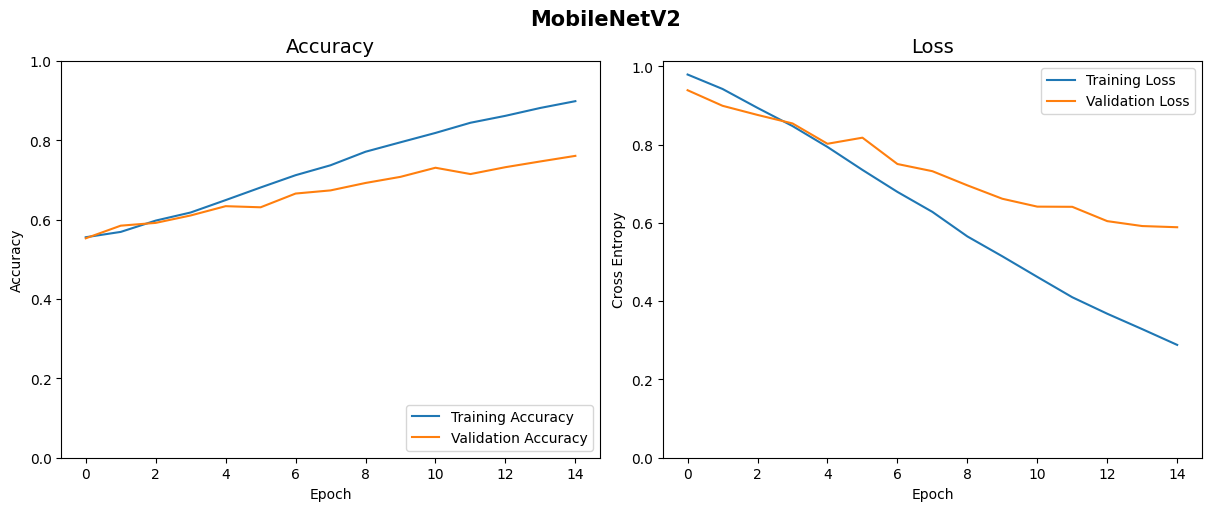

In [39]:
# training and validation accuracy
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5), constrained_layout=True)

acc = history_mobilenet.history['accuracy']
val_acc = history_mobilenet.history['val_accuracy']

ax[0].plot(acc, label='Training Accuracy')
ax[0].plot(val_acc, label='Validation Accuracy')
ax[0].legend(loc='lower right')
ax[0].set(xlabel='Epoch', ylabel='Accuracy', ylim=[min(plt.ylim()),1])
ax[0].set_title('Accuracy', size=14)

# training and validation loss
loss = history_mobilenet.history['loss']
val_loss = history_mobilenet.history['val_loss']

ax[1].plot(loss, label='Training Loss')
ax[1].plot(val_loss, label='Validation Loss')
ax[1].legend(loc='upper right')
ax[1].set(xlabel='Epoch', ylabel='Cross Entropy', ylim=[0,max(plt.ylim())])
ax[1].set_title('Loss', size=14)

fig.suptitle("MobileNetV2", fontweight="bold", size=15)
plt.show()

- VGG16

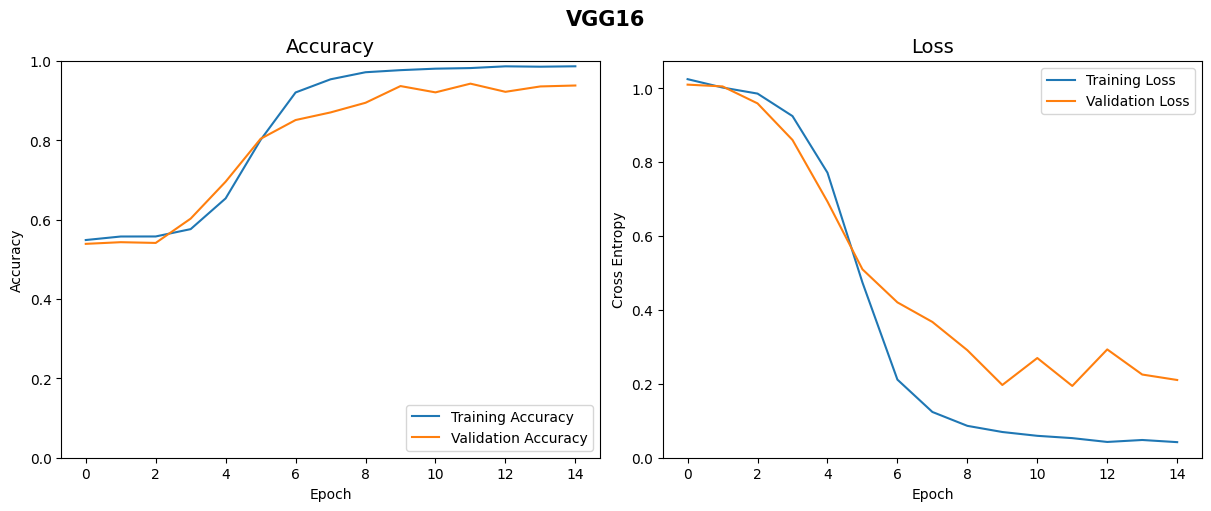

In [15]:
# training and validation accuracy
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5), constrained_layout=True)

acc = history_vgg.history['accuracy']
val_acc = history_vgg.history['val_accuracy']

ax[0].plot(acc, label='Training Accuracy')
ax[0].plot(val_acc, label='Validation Accuracy')
ax[0].legend(loc='lower right')
ax[0].set(xlabel='Epoch', ylabel='Accuracy', ylim=[min(plt.ylim()),1])
ax[0].set_title('Accuracy', size=14)

# training and validation loss
loss = history_vgg.history['loss']
val_loss = history_vgg.history['val_loss']

ax[1].plot(loss, label='Training Loss')
ax[1].plot(val_loss, label='Validation Loss')
ax[1].legend(loc='upper right')
ax[1].set(xlabel='Epoch', ylabel='Cross Entropy', ylim=[0,max(plt.ylim())])
ax[1].set_title('Loss', size=14)

fig.suptitle("VGG16", fontweight="bold", size=15)
plt.show()

- InceptionV3

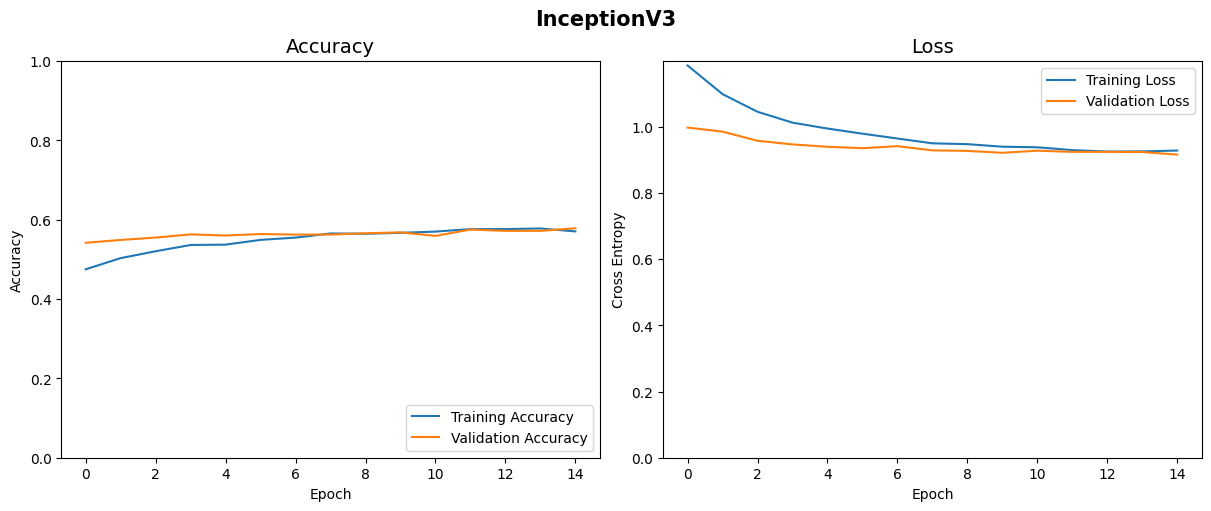

In [24]:
# training and validation accuracy
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5), constrained_layout=True)

acc = history_inception.history['accuracy']
val_acc = history_inception.history['val_accuracy']

ax[0].plot(acc, label='Training Accuracy')
ax[0].plot(val_acc, label='Validation Accuracy')
ax[0].legend(loc='lower right')
ax[0].set(xlabel='Epoch', ylabel='Accuracy', ylim=[min(plt.ylim()),1])
ax[0].set_title('Accuracy', size=14)

# training and validation loss
loss = history_inception.history['loss']
val_loss = history_inception.history['val_loss']

ax[1].plot(loss, label='Training Loss')
ax[1].plot(val_loss, label='Validation Loss')
ax[1].legend(loc='upper right')
ax[1].set(xlabel='Epoch', ylabel='Cross Entropy', ylim=[0,max(plt.ylim())])
ax[1].set_title('Loss', size=14)

fig.suptitle("InceptionV3", fontweight="bold", size=15)
plt.show()

- en-CNN

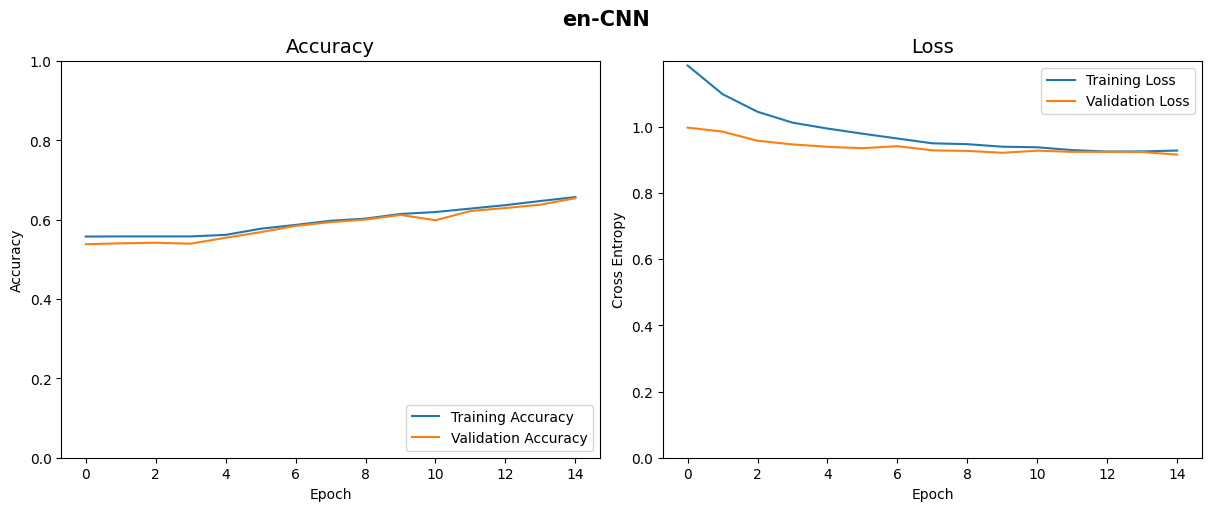

In [46]:
# training and validation accuracy
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5), constrained_layout=True)

acc = history_cnn.history['accuracy']
val_acc = history_cnn.history['val_accuracy']

ax[0].plot(acc, label='Training Accuracy')
ax[0].plot(val_acc, label='Validation Accuracy')
ax[0].legend(loc='lower right')
ax[0].set(xlabel='Epoch', ylabel='Accuracy', ylim=[min(plt.ylim()),1])
ax[0].set_title('Accuracy', size=14)

# training and validation loss
loss = history_inception.history['loss']
val_loss = history_inception.history['val_loss']

ax[1].plot(loss, label='Training Loss')
ax[1].plot(val_loss, label='Validation Loss')
ax[1].legend(loc='upper right')
ax[1].set(xlabel='Epoch', ylabel='Cross Entropy', ylim=[0,max(plt.ylim())])
ax[1].set_title('Loss', size=14)

fig.suptitle("en-CNN", fontweight="bold", size=15)
plt.show()

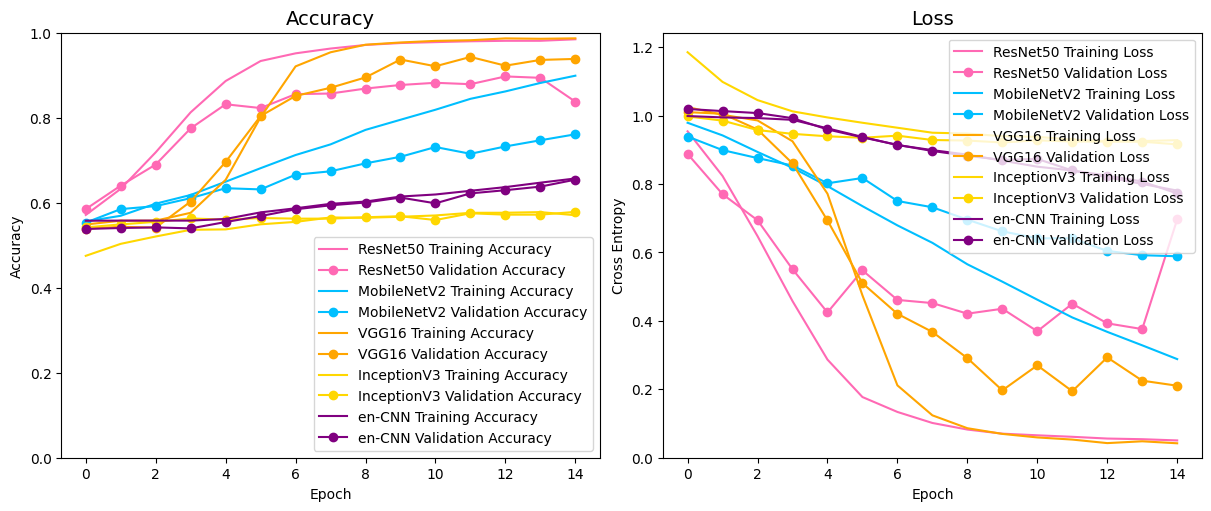

In [47]:
# training and validation accuracy
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5), constrained_layout=True)

acc_resnet = history_resnet.history['accuracy']
val_acc_resnet = history_resnet.history['val_accuracy']

acc_mobilenet = history_mobilenet.history['accuracy']
val_acc_mobilenet = history_mobilenet.history['val_accuracy']

acc_vgg= history_vgg.history['accuracy']
val_acc_vgg = history_vgg.history['val_accuracy']

acc_inception = history_inception.history['accuracy']
val_acc_inception = history_inception.history['val_accuracy']

acc_cnn = history_cnn.history['accuracy']
val_acc_cnn = history_cnn.history['val_accuracy']

ax[0].plot(acc_resnet, label='ResNet50 Training Accuracy', color='HotPink', )
ax[0].plot(val_acc_resnet, label='ResNet50 Validation Accuracy', color='HotPink', marker='o')

ax[0].plot(acc_mobilenet, label='MobileNetV2 Training Accuracy', color='DeepSkyBlue', )
ax[0].plot(val_acc_mobilenet, label='MobileNetV2 Validation Accuracy', color='DeepSkyBlue', marker='o')

ax[0].plot(acc_vgg, label='VGG16 Training Accuracy', color='orange', )
ax[0].plot(val_acc_vgg, label='VGG16 Validation Accuracy', color='orange', marker='o')

ax[0].plot(acc_inception, label='InceptionV3 Training Accuracy', color='gold', )
ax[0].plot(val_acc_inception, label='InceptionV3 Validation Accuracy', color='gold', marker='o')

ax[0].plot(acc_cnn, label='en-CNN Training Accuracy', color='purple', )
ax[0].plot(val_acc_cnn, label='en-CNN Validation Accuracy', color='purple', marker='o')

ax[0].legend(loc='lower right')
ax[0].set(xlabel='Epoch', ylabel='Accuracy', ylim=[min(plt.ylim()),1])
ax[0].set_title('Accuracy', size=14)

# training and validation loss
loss_resnet = history_resnet.history['loss']
val_loss_resnet = history_resnet.history['val_loss']

loss_mobilenet = history_mobilenet.history['loss']
val_loss_mobilenet = history_mobilenet.history['val_loss']

loss_vgg = history_vgg.history['loss']
val_loss_vgg = history_vgg.history['val_loss']

loss_inception = history_inception.history['loss']
val_loss_inception = history_inception.history['val_loss']

loss_cnn = history_cnn.history['loss']
val_loss_cnn = history_cnn.history['val_loss']

ax[1].plot(loss_resnet, label='ResNet50 Training Loss', color='HotPink', )
ax[1].plot(val_loss_resnet, label='ResNet50 Validation Loss', color='HotPink', marker='o')

ax[1].plot(loss_mobilenet, label='MobileNetV2 Training Loss', color='DeepSkyBlue', )
ax[1].plot(val_loss_mobilenet, label='MobileNetV2 Validation Loss', color='DeepSkyBlue', marker='o')

ax[1].plot(loss_vgg, label='VGG16 Training Loss', color='orange', )
ax[1].plot(val_loss_vgg, label='VGG16 Validation Loss', color='orange', marker='o')

ax[1].plot(loss_inception, label='InceptionV3 Training Loss', color='gold', )
ax[1].plot(val_loss_inception, label='InceptionV3 Validation Loss', color='gold', marker='o')

ax[1].plot(loss_cnn, label='en-CNN Training Loss', color='purple', )
ax[1].plot(val_loss_cnn, label='en-CNN Validation Loss', color='purple', marker='o')

ax[1].legend(loc='upper right')
ax[1].set(xlabel='Epoch', ylabel='Cross Entropy', ylim=[0,max(plt.ylim())])
ax[1].set_title('Loss', size=14)

plt.show()